In [34]:
import os, shutil, pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import image_dataset_from_directory

In [35]:
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat", "train"),
    image_size=(224, 224),
    batch_size=4
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat", "validation"),
    image_size=(224, 224),
    batch_size=2
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat", "test"),
    image_size=(224, 224),
    batch_size=2
)

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [36]:
num_classes = 3

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

# Apply augmentation only to the training dataset.
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

def preprocess_dataset(dataset):
    def _process(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        y = keras.utils.to_categorical(y, num_classes)
        return x, y
    return dataset.map(_process)

#train_dataset = preprocess_dataset(train_dataset)
#validation_dataset = preprocess_dataset(validation_dataset)

Liitetään VGG16 mallin päälle oma opetettava opetettava malli. Lukitaan VGG16:n konvoluutiokerrokset ja koulutetaan vain oma malli.

In [37]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)  

model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        771 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.3929 - loss: 23.2021 - val_accuracy: 0.5556 - val_loss: 12.7177
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.7484 - loss: 16.0827 - val_accuracy: 0.8889 - val_loss: 8.3048
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.8251 - loss: 4.2585 - val_accuracy: 0.8148 - val_loss: 7.3510
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.8474 - loss: 3.7251 - val_accuracy: 0.7407 - val_loss: 7.5102
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.9424 - loss: 1.4652 - val_accuracy: 0.7407 - val_loss: 11.6553
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9086 - loss: 3.2888 - val_accuracy: 0.8519 - val_loss: 9.6877
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9501 - loss: 2.3493 - val_accuracy: 0.7778 - val_loss: 10.7777
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.9388 - loss: 1.7697 - val

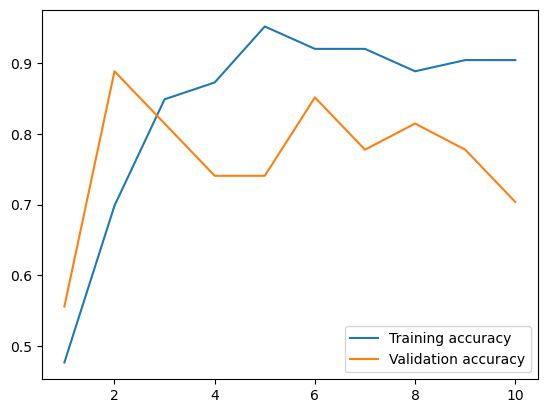

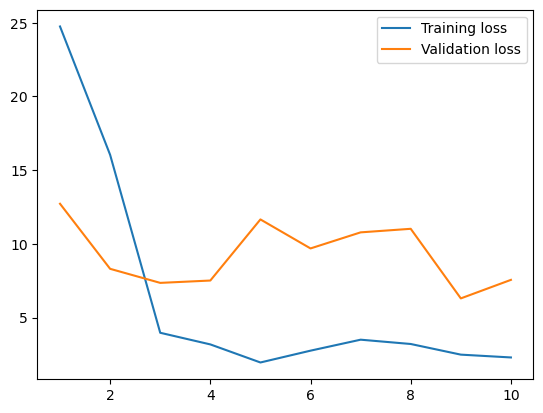

In [40]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9658 - loss: 0.2125
Test accuracy: 0.926


Avataan lukitus VGG16:n ylimmistä konvoluutiokerroksista ja hienosäädetään niiden koulutusta yhdessä oman luokittelukerroksen kanssa.

In [42]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)


In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.9627 - loss: 0.4588 - val_accuracy: 0.7037 - val_loss: 6.2981
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.9485 - loss: 1.0713 - val_accuracy: 0.8148 - val_loss: 4.1606
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.9724 - loss: 0.4078 - val_accuracy: 0.7407 - val_loss: 4.8692
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.9558 - loss: 0.2452 - val_accuracy: 0.7778 - val_loss: 4.1448
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9806 - loss: 0.3776 - val_accuracy: 0.8148 - val_loss: 3.7956
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.9783 - loss: 0.0270 - val_accuracy: 0.8519 - val_loss: 3.8159
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.9686 - loss: 0.5992 - val_accuracy: 0.8889 - val_loss: 3.8313
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9718 - loss: 0.3309 - val_accu

In [44]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9224 - loss: 0.1513
Test accuracy: 0.962963
